### Quantify differences between images

In [1]:
import h5py
from ipywidgets import interact
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
d = '../h5_files/'
!ls {d} | grep h5

20161115_E16019.h5
20161115_E16020.h5
20161115_E16088.h5
20161115_E16095.h5
20161117_E16014.h5
20161117_E16018.h5
20161117_E16095.h5


In [3]:
fname = '20161115_E16088.h5'
f = h5py.File(d+fname)
scan = f['scan_0010/data/image_data']

KeyError: 'Unable to open object (Component not found)'

Raw data:

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


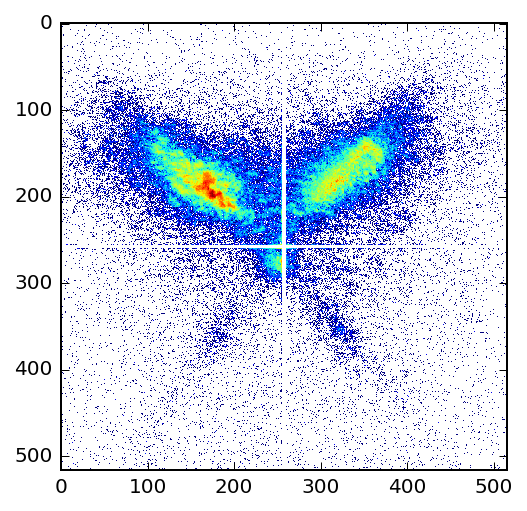

In [5]:
@interact(i=(0,scan.shape[0]))
def plt_scan(i):
    plt.imshow(np.log(scan[i]),interpolation='none')

Let's play with it. The mean squared error equation:
$$
\text{MSE} = \dfrac{1}{mn} \sum^{m-1}_{i=0} \sum^{n-1}_{j=0} \big[I(i,j) - K(i,j)
 \big]^{2}$$

In [6]:
def mse(imgA, imgB):
    # the sum of the squared differences between the two images
    err = np.sum((imgA.astype('float') - imgB.astype('float')) ** 2)
    err /= float(imgA.shape[0] * imgA.shape[1])
    return err

Plot of the difference between the first image and the subsequent ones as quantified by the MSE

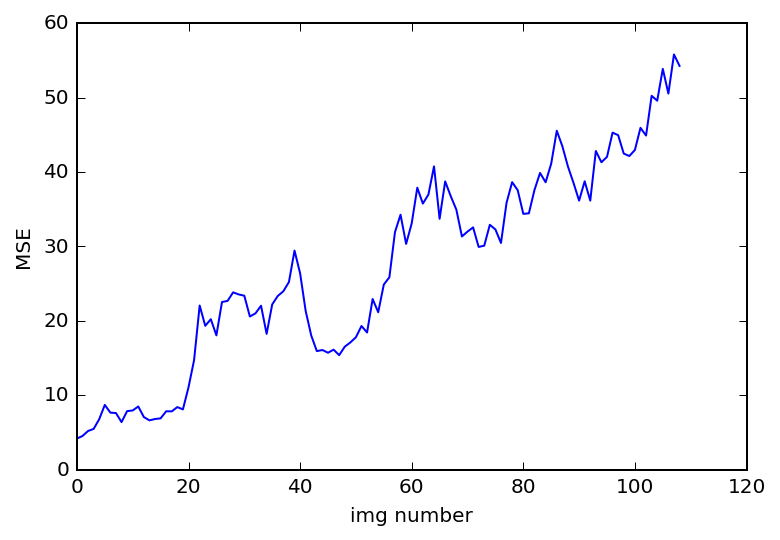

In [119]:
errors = []
for scan_no in range(1,scan.shape[0]):
    err = mse(scan[0],scan[scan_no])
    errors.append(err)
plt.plot(errors)
plt.ylabel('MSE')
plt.xlabel('img number');

Don't forget that most of the variation in the image comes from the background, which is randomly changing. But this then should be on average constant, whereas some sort of linear trend with a modulation seems to be happening.

More reliable is the Structural Similarity Index, developed by [Wang et al.](http://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf). It attempts to model the perceived change (instead of the errors) in the structural information of the image. It also compares two windows instead of the entire image. Returns values from -1 to 1, the latter only reachable for two exactly identical images.

In [7]:
from skimage.measure import compare_ssim as ssim
import cv2

In [8]:
# for the SSI, 1 is perfect match
errors = []
for scan_no in range(1,scan.shape[0]):
    err = ssim(scan[0],scan[scan_no])
    errors.append(err)

plt.plot(errors)
plt.ylabel('SSI')
plt.xlabel('img number');

AttributeError: shape

What happens if you play with the window size in the SSIM algorithm:

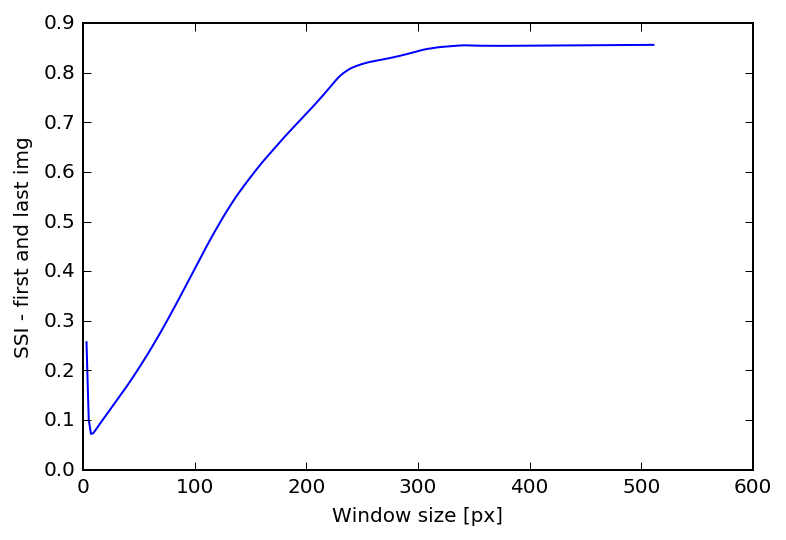

In [125]:
ls = list()
for number in range(3,512,2): 
    s = ssim(scan[0], scan[109], win_size=number)
    ls.append(s)
    
plt.plot(range(3,512,2), ls)
plt.ylabel('SSI - first and last img')
plt.xlabel('Window size [px]')

Focus on a single domain satellite.

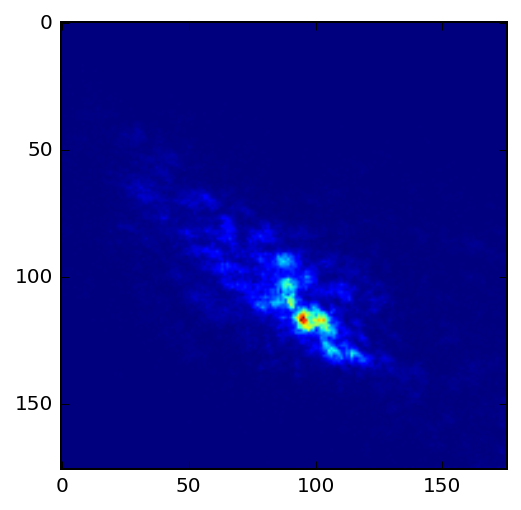

In [74]:
plt.imshow(scan[0][80:256,80:256]) # Left peak

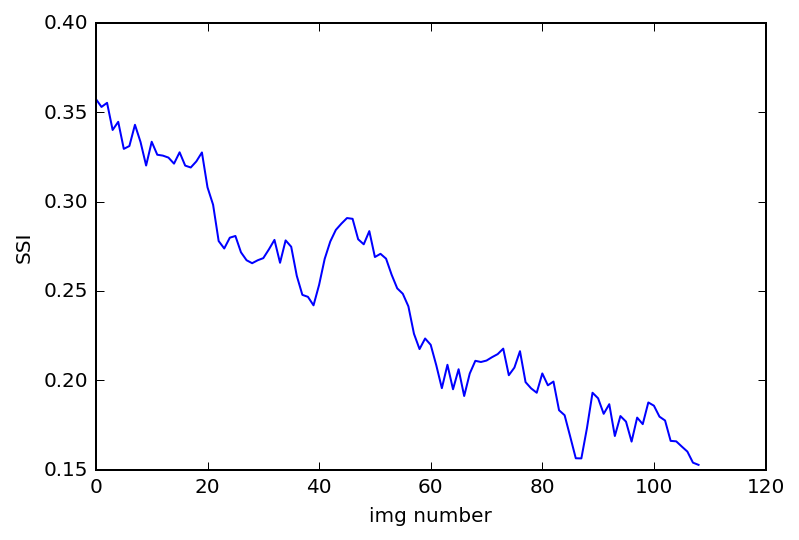

In [124]:
errors = []
for scan_no in range(1,scan.shape[0]):
    err = ssim(scan[0][80:256,80:256],scan[scan_no][80:256,80:256])
    errors.append(err)

plt.plot(errors)
plt.ylabel('SSI')
plt.xlabel('img number');

And on the other domain:

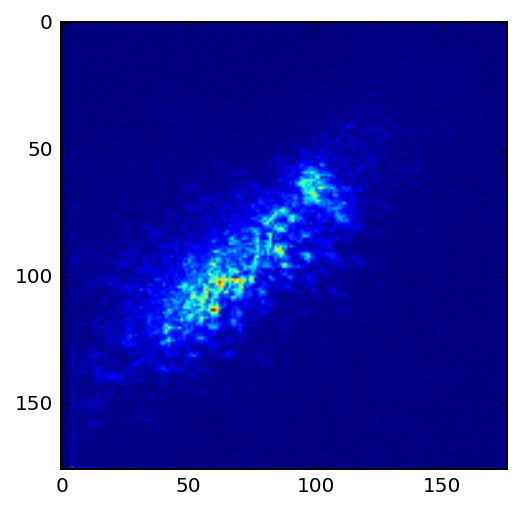

In [80]:
plt.imshow(scan[0][80:256,256:432])

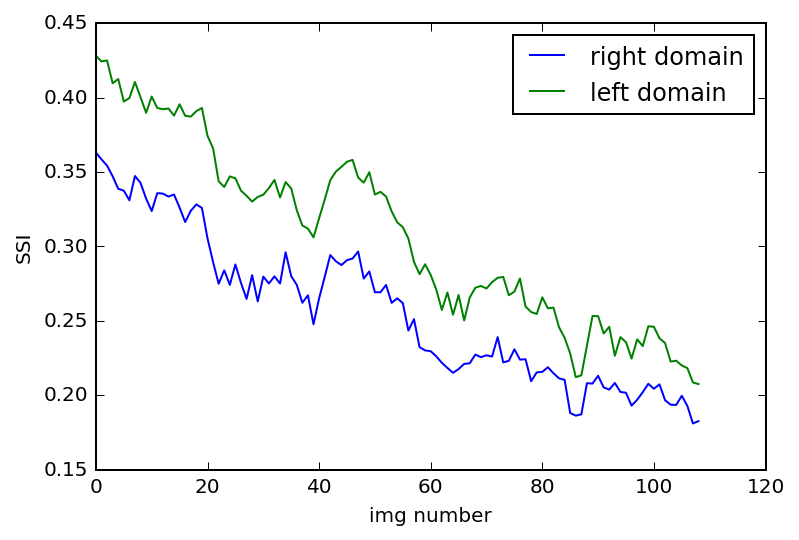

In [126]:
# for the SSI, 1 is perfect match
errors1, errors2 = [],[]
for scan_no in range(1,scan.shape[0]):
    err = ssim(scan[0][80:256,256:432],scan[scan_no][80:256,256:432], win_size=11)
    errors1.append(err)
for scan_no in range(1,scan.shape[0]):
    err = ssim(scan[0][80:256,80:256],scan[scan_no][80:256,80:256], win_size=11)
    errors2.append(err)

plt.plot(errors1, label='right domain')
plt.plot(errors2, label='left domain')
plt.ylabel('SSI')
plt.xlabel('img number')
plt.legend();

Kmaps!

In [9]:
import PyMca5 as mca

specdir = '/Users/ezatterin/Documents/UCL_phd/data/ESRF/IHR_20161114/spec/'
files = !ls {specdir} | grep spec | grep fast | grep E16088
for index,fname in enumerate(files): print index,fname
roi = 'mpx4int'

0 20161115_E16088_fast_00009.spec
1 20161115_E16088_fast_00011.spec
2 20161115_E16088_fast_00019.spec
3 20161115_E16088_fast_00220.spec
4 20161115_E16088_fast_00223.spec


In [10]:
sf = mca.specfile.Specfile(specdir+files[3]) 

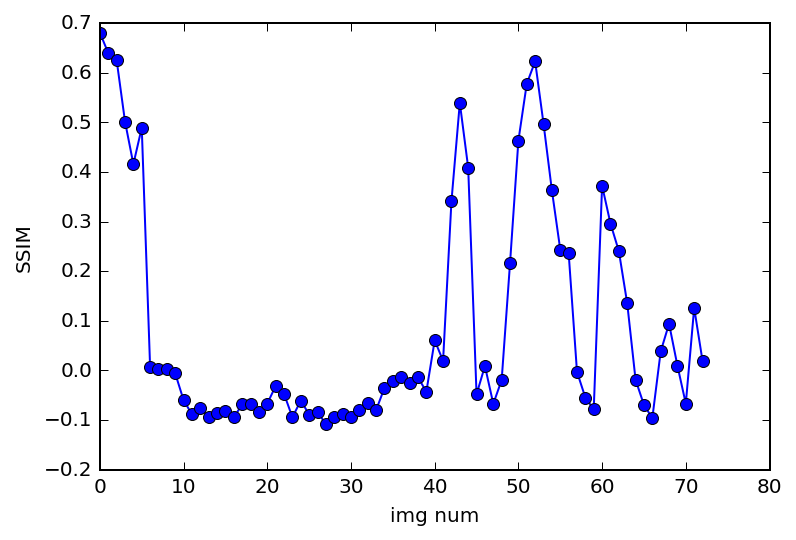

In [12]:
kmaps = []
for scan_no in range(1,int(sf.list()[2:])): # skip the first scan
    
    scan = sf[scan_no]
    data = scan.data()
    index_list = scan.alllabels()
    rawdata = data[index_list.index(roi)]
    new_shape = (int(scan.command().split()[8]), int(scan.command().split()[4]))
    rawdata.shape = new_shape
    kmaps.append(rawdata)   

err = []
for scan_no in range(1,len(kmaps)):
    s = ssim(kmaps[0],kmaps[scan_no],gaussian_weights=True,sigma=1.5,use_sample_covariance=False)
    err.append(s)
    
plt.plot(err, '-o')
plt.ylabel('SSIM')
plt.xlabel('img num')

In [132]:
ssim?